In [2]:
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import to_categorical
import os
import cv2
from tqdm import tqdm
import random
import pickle
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [3]:
DATADIR = "/Users/ryanklapper/Desktop/2020/Data Science/search-bing-api/dataset/"

CATEGORIES = ["Bagpipes","Harmonica","Flute","Piano","Saxophone","Guitar",]
training_data = []
IMG_SIZE = 350
def train():
    for category in CATEGORIES:  # iterate each instrument

        path = os.path.join(DATADIR,category)  # create path to different instruments
        class_num = CATEGORIES.index(category)  # get the classification of each instrument

        for img in tqdm(os.listdir(path)):  # iterate over each image in each instrument
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                training_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:
                pass
            
train()
# Shuffling data so each instrument is trained without bias
random.shuffle(training_data)

X = []
y = []
for music_features,music_label in training_data:
    X.append(music_features)
    y.append(music_label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y = np.array(y)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=13)
input_shape = (IMG_SIZE, IMG_SIZE, 1)

# Prepare the training images
X_train = X_train.reshape(X_train.shape[0], IMG_SIZE, IMG_SIZE, 1)
X_train = X_train.astype('float32')
X_train /= 255

# Prepare the validation images
X_val = X_val.reshape(X_val.shape[0], IMG_SIZE, IMG_SIZE, 1)
X_val = X_val.astype('float32')
X_val /= 255

100%|██████████| 201/201 [00:04<00:00, 48.64it/s]


In [4]:
DATADIR_TEST = "/Users/ryanklapper/Desktop/2020/Data Science/images"
testing_data = []
def test():
    for img in tqdm(os.listdir(DATADIR_TEST)):
        try:
            img_test_array = cv2.imread(os.path.join(DATADIR_TEST,img) ,cv2.IMREAD_GRAYSCALE) # convert to array
            new_test_array = cv2.resize(img_test_array, (IMG_SIZE, IMG_SIZE)) # resize to normalize data size
            testing_data.append([new_test_array])
        except Exception as e:
            pass
test()

# Shuffling data so each image is trained without bias
random.shuffle(testing_data)
X_Test = []

for iss_images in testing_data:
    X_Test.append(iss_images)

X_Test = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

100%|██████████| 7294/7294 [05:23<00:00, 22.52it/s]


In [5]:
pickle_save_X = open("X.pickle","wb")
pickle.dump(X, pickle_save_X)
pickle_save_X.close()

pickle_save_y = open("y.pickle","wb")
pickle.dump(y, pickle_save_y)
pickle_save_y.close()

In [6]:
NAME = "Is-Music-Relevant-CNN"

pickle_load_X = open("X.pickle","rb")
X = pickle.load(pickle_load_X)

pickle_load_y = open("y.pickle","rb")
y = pickle.load(pickle_load_y)

X = X/255.0

gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                               height_shift_range=0.08, zoom_range=0.08)
batches = gen.flow(X, y, batch_size=32)
val_batches = gen.flow(X_val, y_val, batch_size=32)

# Creation of the model
model = Sequential()
# Layers of the model
model.add(Conv2D(30, (3, 3), input_shape=X.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(30, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(6))
model.add(Activation("sigmoid"))

# Creation of tensorboard to look at statistics
tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 348, 348, 30)      300       
_________________________________________________________________
activation (Activation)      (None, 348, 348, 30)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 174, 174, 30)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 172, 172, 30)      8130      
_________________________________________________________________
activation_1 (Activation)    (None, 172, 172, 30)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 86, 86, 30)        0         
_________________________________________________________________
flatten (Flatten)            (None, 221880)            0

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 35 steps, validate for 0.3 steps
Epoch 1/4
35/35 [==============================] - 45s 1s/step - loss: 1.7023 - accuracy: 0.2830 - val_loss: 4.2307 - val_accuracy: 0.5000
Epoch 2/4
35/35 [==============================] - 52s 1s/step - loss: 1.0769 - accuracy: 0.6337 - val_loss: 3.9998 - val_accuracy: 0.6562
Epoch 3/4
35/35 [==============================] - 44s 1s/step - loss: 0.9431 - accuracy: 0.6949 - val_loss: 2.6240 - val_accuracy: 0.7188
Epoch 4/4
35/35 [==============================] - 47s 1s/step - loss: 0.7498 - accuracy: 0.7534 - val_loss: 2.7320 - val_accuracy: 0.7188
Test loss: 0.6141189744049066
Test accuracy: 0.7804024


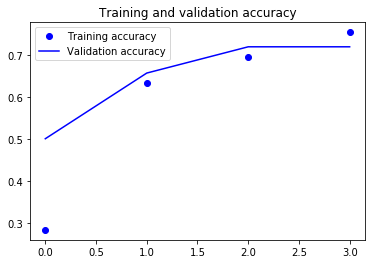

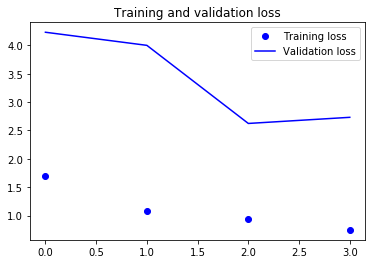

In [7]:
action = model.fit_generator(batches, steps_per_epoch=len(X)//32, epochs=4,
                    validation_data=val_batches, validation_steps=0.3,callbacks=[tensorboard])
test_statistics = model.evaluate(X, y, verbose=0)
print('Test loss:', test_statistics[0])
print('Test accuracy:', test_statistics[1])
%matplotlib inline

accuracy = action.history['accuracy']
val_accuracy = action.history['val_accuracy']
loss = action.history['loss']
val_loss = action.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()